# Twitter Sentiment Analysis
En este notebook vas a ver un ejemplo de los procesos necesarios para realizar un análisis de sentimientos sobre Tweets. Para ello tendremos que seguir los siguientes pasos:
1. Conseguir un Corpus: no es más que una base de datos de texto etiquetado
2. Limpiar los datos
3. Entrenar un modelo con el corpus
4. Cargar un lexicon sentimental
5. Hacer un modelo no_supervisado basado en el lexicon
6. Compararlo con el modelo anteriormente entrenado

**Estos programas son muy útiles en campañas de marketing, para monitorizar el lanzamiento de un nuevo producto, realizar seguimiento en Twitter de eventos, o simplemente tener monitorizadas ciertas cuentas o hashtags para tener un programa de análisis real time.**

## 1. Corpus
Para conseguir el corpus tendremos que registrarnos en la [página del TASS](http://tass.sepln.org/tass_data/download.php), que se trata de una asociación de análisis semántico que encargada de recopilar texto y mantenerlo etiquetado. 

Para datasets en ingles lo tenemos más fácil ya que con librerías como [TextBlob](https://textblob.readthedocs.io/en/dev/) podemos predecir directamente la polaridad del Tweet, con modelos ya preentrenados. En el caso del castellano necesitamos acudir a un corpus etiquetado para entrenar nuestro modelo.

Registrate en el TASS y accede a sus corpus a través de un link que te llegará al correo tras el registro.

![imagen](img/tass_register.png)


Una vez estes registrado, descárgate el corpus de tweets en español de entrenamiento. En este punto lo ideal es coger un corpus que se adapte lo máximo posible a los tipos de tweets que intentamos predecir, es decir, si queremos predecir tweets sobre política, procurar elegir un corpus que tenga vocabulario de política.

En este notebook se va a elegir un corpus genérico con no demasiados registros para aligerar la limpieza y entrenamiento de los modelos.

![imagen](img/download_train_spanish.png)

### Importamos librerias

In [422]:
import pandas as pd
import re
import seaborn as sns
import xml.etree.ElementTree as ET

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

### Leemos el dataset

In [423]:
tree = ET.parse('data/general-train-tagged.xml')
root = tree.getroot()

In [424]:
raw_dict = {
    'User': [],
    'Content': [],
    'Date': [],
    'Lang': [],
    'Polarity': [],
    'Type': []
}

for i in root.iter('tweet'):
    user = i.find('user').text
    content = i.find('content').text
    date = i.find('date').text
    lang = i.find('lang').text
    polarity = i.find('sentiments').find('polarity').find('value').text
    tweet_type = i.find('sentiments').find('polarity').find('type').text
    
    raw_dict['User'].append(user)
    raw_dict['Content'].append(content)
    raw_dict['Date'].append(date)
    raw_dict['Lang'].append(lang)
    raw_dict['Polarity'].append(polarity)
    raw_dict['Type'].append(tweet_type)
    
df = pd.DataFrame(raw_dict)
print(df.shape)

df.head()

(7219, 6)


,User,Content,Date,Lang,Polarity,Type
0,ccifuentes,"Salgo de #VeoTV , que día más largoooooo...",2011-12-02T00:47:55,es,NONE,AGREEMENT
1,CarmendelRiego,@PauladeLasHeras No te libraras de ayudar me/n...,2011-12-02T00:49:40,es,NEU,DISAGREEMENT
2,CarmendelRiego,@marodriguezb Gracias MAR,2011-12-02T00:57:40,es,P,AGREEMENT
3,mgilguerrero,"Off pensando en el regalito Sinde, la que se v...",2011-12-02T02:33:37,es,N+,AGREEMENT
4,paurubio,Conozco a alguien q es adicto al drama! Ja ja ...,2011-12-02T02:59:03,es,P+,AGREEMENT


### Columna de polaridad

In [425]:
# Vemos los valores unicos de la columna de polaridad
df.Polarity.unique()

array(['NONE', 'NEU', 'P', 'N+', 'P+', 'N'], dtype=object)

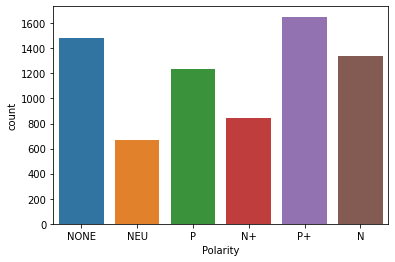

In [426]:
sns.countplot(x ='Polarity', data = df);

#### Columna de tipo

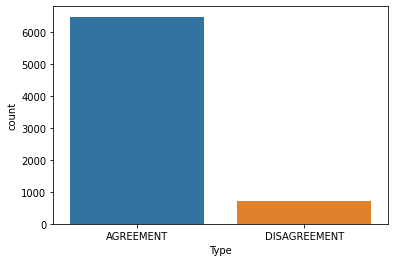

In [427]:
sns.countplot(x ='Type', data = df);

## 2. Limpieza de datos
#### Polaridad
Vamos a clasificar los Tweets como buenos o malos, por lo que haremos la siguiente agrupación de la polaridad

In [428]:
def polaridad_fun(x):
    if x in ('P', 'P+'):
        return 0
    elif x in ('N', 'N+'):
        return 1

In [429]:
# Nos cargamos los NONE y los neutros
df = df[~df['Polarity'].isin(['NONE','NEU'])]
df['Polarity'].unique()

array(['P', 'N+', 'P+', 'N'], dtype=object)

In [430]:
# Pasamos la columna a 1s y 0s. Y el tipo
df.loc[:,'Polarity'] = df['Polarity'].apply(polaridad_fun)
df['Polarity'].unique()

array([0, 1])

#### Idioma
Nos quedamos con los tweets en español. Si no tuviésemos esa columna podríamos acudir a librerías como `langid` o `langdetect`.

In [431]:
# Filtramos los tweets en español
df = df[df['Lang'] == 'es']

In [432]:
# Vemos con cuantos registros nos hemos quedado despues del filtrado
df.shape

(5066, 6)

#### Duplicados

In [433]:
# Eliminamos los duplicados
df.drop_duplicates(subset = 'Content', inplace = True)
df.shape

(5052, 6)

#### Signos de puntuación
Eliminamos signos de puntuación: puntos, comas, interrogaciones, paréntesis

In [434]:
df['Content'].head()

2                            @marodriguezb Gracias MAR
3    Off pensando en el regalito Sinde, la que se v...
4    Conozco a alguien q es adicto al drama! Ja ja ...
6    Toca @crackoviadeTV3 . Grabación dl especial N...
8    Buen día todos! Lo primero mandar un abrazo gr...
Name: Content, dtype: object

In [435]:
import re

signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")

def signs_tweets(tweet):
    return signos.sub('', tweet.lower())

df['Content_bck'] = df['Content']
df['Content'] = df['Content'].apply(signs_tweets)
df['Content'].head()

2                            @marodriguezb gracias mar
3    off pensando en el regalito sinde la que se va...
4    conozco a alguien q es adicto al drama ja ja j...
6    toca @crackoviadetv  grabación dl especial nav...
8    buen día todos lo primero mandar un abrazo gra...
Name: Content, dtype: object

In [436]:
df.head()

,User,Content,Date,Lang,Polarity,Type,Content_bck
2,CarmendelRiego,@marodriguezb gracias mar,2011-12-02T00:57:40,es,0,AGREEMENT,@marodriguezb Gracias MAR
3,mgilguerrero,off pensando en el regalito sinde la que se va...,2011-12-02T02:33:37,es,1,AGREEMENT,"Off pensando en el regalito Sinde, la que se v..."
4,paurubio,conozco a alguien q es adicto al drama ja ja j...,2011-12-02T02:59:03,es,0,AGREEMENT,Conozco a alguien q es adicto al drama! Ja ja ...
6,Carlos_Latre,toca @crackoviadetv grabación dl especial nav...,2011-12-02T07:00:50,es,0,AGREEMENT,Toca @crackoviadeTV3 . Grabación dl especial N...
8,nacho_uriarte,buen día todos lo primero mandar un abrazo gra...,2011-12-02T07:45:05,es,0,AGREEMENT,Buen día todos! Lo primero mandar un abrazo gr...


#### Eliminamos links

In [437]:
def remove_links(df):
    return " ".join(['{link}' if ('http') in word else word for word in df.split()])

df['Content'] = df['Content'].apply(remove_links)

#### Otros
Podríamos hacer un preprocesado mucho más fino:
1. Hashtags
2. Menciones
3. Abreviaturas
4. Faltas de ortografía
5. Risas

## 3. Modelo
Para montar el modelo tendremos que seguir los siguientes pasos
1. Eliminamos las stopwords
2. Aplicamos un stemmer, SnowBall por ejemplo

#### Stopwords

In [438]:
from nltk.corpus import stopwords
# nltk.download('stopwords')

spanish_stopwords = stopwords.words('spanish')

def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in spanish_stopwords])

df['Content'] = df['Content'].apply(remove_stopwords)
df.head()

,User,Content,Date,Lang,Polarity,Type,Content_bck
2,CarmendelRiego,@marodriguezb gracias mar,2011-12-02T00:57:40,es,0,AGREEMENT,@marodriguezb Gracias MAR
3,mgilguerrero,off pensando regalito sinde va sgae van corrup...,2011-12-02T02:33:37,es,1,AGREEMENT,"Off pensando en el regalito Sinde, la que se v..."
4,paurubio,conozco alguien q adicto drama ja ja ja suena d,2011-12-02T02:59:03,es,0,AGREEMENT,Conozco a alguien q es adicto al drama! Ja ja ...
6,Carlos_Latre,toca @crackoviadetv grabación dl especial navi...,2011-12-02T07:00:50,es,0,AGREEMENT,Toca @crackoviadeTV3 . Grabación dl especial N...
8,nacho_uriarte,buen día primero mandar abrazo grande miguel f...,2011-12-02T07:45:05,es,0,AGREEMENT,Buen día todos! Lo primero mandar un abrazo gr...


#### Stemmer

In [439]:
df_before_stemmer = df.copy()

In [440]:
from nltk.stem.snowball import SnowballStemmer

def spanish_stemmer(x):
    stemmer = SnowballStemmer('spanish')
    return " ".join([stemmer.stem(word) for word in x.split()])

df['Content'] = df['Content'].apply(spanish_stemmer)

#### Seleccionamos columnas
Nos quedamos con las columnas que nos interesan para el modelo

In [441]:
df_old = df.copy()

In [442]:
df = df[['Content', 'Polarity']]

#### Vectorizamos el dataset

In [443]:
vectorizer = CountVectorizer()

#### Montamos Pipeline
Modelos que suelen funcionar bien con pocas observaciones y muchas features son la Regresión logística el LinearSVC o Naive Bayes.

In [444]:
from sklearn.linear_model import LogisticRegression

#### Entrenamos

In [445]:
from sklearn.model_selection import train_test_split

In [446]:
X_train,X_test,y_train,y_test = train_test_split(df['Content'],df['Polarity'], test_size = 0.2)

In [447]:
#LinearSVC() es el clasificador
pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', LogisticRegression()),
])

# Aqui definimos el espacio de parámetros a explorar
parameters = {
    'vect__max_df': (0.5,1),
    'vect__min_df': (10, 20,50),
    'vect__max_features': (500, 1000, None),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigramas or bigramas
    'cls__C': (0.2, 0.5, 0.7),
    'cls__penalty': (None, "l2"),
    'cls__max_iter': (500, 1000)
}


grid_search = GridSearchCV(pipeline,
                           parameters,
                           cv=5,
                           n_jobs=-1 ,
                           scoring='accuracy')

In [448]:
%%time
grid_search.fit(X_train,
                y_train)

CPU times: user 5.55 s, sys: 279 ms, total: 5.83 s
Wall time: 48.1 s


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1620 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('cls', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cls__C': (0.2, 0.5, 0.7),
                         'cls__max_iter': (500, 1000),
                         'cls__penalty': (None, 'l2'), 'vect__max_df': (0.5, 1),
                         'vect__max_features': (500, 1000, None),
                         'vect__min_df': (10, 20, 50),
                         'vect__ngram_range': ((1, 1), (1, 2))},
             scoring='accuracy')

In [449]:
print("Best params:", grid_search.best_params_)
print("Best acc:", grid_search.best_score_)
print("Best model:", grid_search.best_estimator_)

Best params: {'cls__C': 0.2, 'cls__max_iter': 500, 'cls__penalty': 'l2', 'vect__max_df': 0.5, 'vect__max_features': 1000, 'vect__min_df': 10, 'vect__ngram_range': (1, 2)}
Best acc: 0.7329893279810056
Best model: Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=1000, min_df=10,
                                 ngram_range=(1, 2))),
                ('cls', LogisticRegression(C=0.2, max_iter=500))])


In [450]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [451]:
predictions = grid_search.best_estimator_.predict(X_test)

In [452]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79       582
           1       0.73      0.69      0.71       429

    accuracy                           0.76      1011
   macro avg       0.75      0.75      0.75      1011
weighted avg       0.76      0.76      0.76      1011



### AÑADIMOS OTRAS FEATURES

In [453]:
sonrisas = re.compile("([:;8X]-[\)DP])")
def have_risas_emojis(row):
    if len(sonrisas.findall(row)):
        return 1
    return 0

In [454]:
lagrimas = re.compile("([:;8]-[\(O]+)")
def have_lagrimas_emojis(row):
    if len(lagrimas.findall(row)):
        return 1
    return 0

In [455]:
def word_count(row):
    return len(row)

In [456]:
df["tiene_sonrisas"] = df_old.Content_bck.apply(have_risas_emojis)

In [457]:
df["tiene_lagrimas"] = df_old.Content_bck.apply(have_lagrimas_emojis)

In [458]:
df["cuenta_tokens"] = df.Content.apply(word_count)

In [459]:
preprocessing = ColumnTransformer([
    ("vect",CountVectorizer(),"Content")],
    remainder = "passthrough")
new_pipeline = Pipeline([
    ("preprocesado",preprocessing),
    ("cls",LogisticRegression())
])

In [460]:
parameters = {
   'vect__max_df': (0.5,1),
    'vect__min_df': (10, 20,50),
    'vect__max_features': (500, 1000, None),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigramas or bigramas
    'cls__C': (0.2, 0.5, 0.7),
    'cls__penalty': (None, "l2"),
    'cls__max_iter': (500, 1000)
}

new_parameters = {
    'preprocesado__vect__ngram_range': ((1, 1), (1, 2)),  # unigramas or bigramas
    'cls__C': (0.2, 0.5, 0.7),
    'cls__penalty': ("none", "l2"),
    'cls__max_iter': (500, 1000)
}


grid_search_new_feats = GridSearchCV(new_pipeline,
                           new_parameters,
                           cv=5,
                           n_jobs=-1 ,
                           scoring='accuracy')

In [461]:
X_train,X_test,y_train,y_test = train_test_split(df[[col for col in df.columns if "Polari" not in col]],df['Polarity'], test_size = 0.2)

In [462]:
%%time
grid_search_new_feats.fit(X_train,
                y_train)

CPU times: user 2.66 s, sys: 2.91 s, total: 5.57 s
Wall time: 36 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesado',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('vect',
                                                                         CountVectorizer(),
                                                                         'Content')])),
                                       ('cls', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cls__C': (0.2, 0.5, 0.7),
                         'cls__max_iter': (500, 1000),
                         'cls__penalty': ('none', 'l2'),
                         'preprocesado__vect__ngram_range': ((1, 1), (1, 2))},
             scoring='accuracy')

In [463]:
print("Best params:", grid_search_new_feats.best_params_)
print("Best acc:", grid_search_new_feats.best_score_)
print("Best model:", grid_search_new_feats.best_estimator_)

Best params: {'cls__C': 0.5, 'cls__max_iter': 500, 'cls__penalty': 'l2', 'preprocesado__vect__ngram_range': (1, 2)}
Best acc: 0.7785179723163911
Best model: Pipeline(steps=[('preprocesado',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('vect',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'Content')])),
                ('cls', LogisticRegression(C=0.5, max_iter=500))])


In [464]:
predictions = grid_search_new_feats.best_estimator_.predict(X_test)

In [465]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       568
           1       0.77      0.65      0.71       443

    accuracy                           0.76      1011
   macro avg       0.76      0.75      0.75      1011
weighted avg       0.76      0.76      0.76      1011



### SUPONGAMOS QUE NO TENEMOS LABEL, "MODELO" NO SUPERVISADO

Cargamos un lexicon "sentimental"

In [466]:
df_lexicon = pd.read_csv("./data/spanish_sentiments.csv")

In [467]:
df_lexicon

,lemma,Polarity
0,a_buena_fé,0.5000
1,a_capella,-0.2500
2,a_cara_descubierta,0.2500
3,a_gusto,0.7500
4,a_la_defensiva,-0.3750
...,...,...
11339,ósmosis,-0.2500
11340,ótico,-0.2500
11341,óxido_nítrico,-0.3750
11342,único,0.3330


Ojo: Está indexado por Lemma

¿Cómo nos afectará?

Nos contruimos nuestro modelo basado en las puntuaciones del lexicon

In [510]:
import numpy as np
def score_lexicon(text,threshold = 0.2):
    score = 0
    cuenta = 0
    for word in text.split():
        #print(word)
        try:
            score += df_lexicon[df_lexicon.lemma == word].Polarity.values[0]
            cuenta += 1
        except:
            #print("No esta en el lexicon")
            continue
    score = score/cuenta if cuenta > 0 else -99999
    return "P" if score > threshold else "N" if score > -99999 else "N/S"
    

Pero no lo podemos aplicar al contenido procesado porque le hemos aplicado el stemming

In [469]:
df.Content

2                                 @marodriguezb graci mar
3       off pens regalit sind va sga van corrupt inten...
4               conozc algui q adict dram ja ja ja suen d
6       toc @crackoviadetv grabacion dl especial navid...
8       buen dia primer mand abraz grand miguel famili...
                              ...                        
7214    indign si nadi rep ello hoy aqui graci rt @lol...
7215                            pobr discrimin muj {link}
7216               cre banc product mujer canc mam {link}
7217                sorprendent huid hoy sen rajoy {link}
7218    #corremarianocorr bien version galleg #correma...
Name: Content, Length: 5052, dtype: object

In [470]:
%%time
df["Polarity_"] = df.iloc[0:100].Content.apply(score_lexicon)

CPU times: user 984 ms, sys: 15.7 ms, total: 1e+03 ms
Wall time: 1 s


In [471]:
df.Polarity_.value_counts()

N/S    74
P      26
Name: Polarity_, dtype: int64

Lo aplicamos al contenido original

In [472]:
%%time
df_old["Polarity_"] = df_old.iloc[0:100].Content_bck.apply(score_lexicon)

CPU times: user 1.51 s, sys: 22.3 ms, total: 1.53 s
Wall time: 1.53 s


In [473]:
df_old.iloc[0:100].Polarity_.value_counts()

N/S    45
P      37
N      18
Name: Polarity_, dtype: int64

Sale algo mejor, pero todavía hay muchos N/S, ¿por qué? Porque espera lemmas. Tenemos que lemmatizar

In [410]:
test.value_counts()

N/S    1
Name: Content_bck, dtype: int64

In [411]:
test

2    N/S
Name: Content_bck, dtype: object

Para lemmatizar aprovecharemos las capacidades de una biblioteca muy potente para NLP, spacy, que además tiene modelos pre-entrenados en español

In [ ]:
#!pip install spacy
#!python -m spacy download es_core_news_sm

In [474]:
import spacy

In [499]:
nlp = spacy.load("es_core_news_lg") # Cargamos el modelo en español

/usr/local/lib/python3.7/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'es_core_news_lg' (3.4.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.5.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [500]:
doc = nlp("Esto es la prueba 23") #Le metemos un texto y además de tokenizarlo, nos va a dar bastantes más features

In [501]:
for token in doc:
    print(token.text, "-> Lema: ", token.lemma_, "-> PoS Tag", token.pos_, "-> Puede ser un numero?", token.like_num)


Esto -> Lema:  este -> PoS Tag PRON -> Puede ser un numero? False
es -> Lema:  ser -> PoS Tag AUX -> Puede ser un numero? False
la -> Lema:  el -> PoS Tag DET -> Puede ser un numero? False
prueba -> Lema:  prueba -> PoS Tag NOUN -> Puede ser un numero? False
23 -> Lema:  23 -> PoS Tag NUM -> Puede ser un numero? True


Utilizemos su lemmatizador para poder aprovechar el lexicon

In [511]:
def new_scorer(doc):
    parsed_doc = nlp(doc)
    for token in parsed_doc:
        new_doc = " ".join([token.lemma_ for token in parsed_doc])
    return score_lexicon(new_doc)
    

In [512]:
df_before_stemmer["New_Pol"] = df_before_stemmer.Content.apply(new_scorer)

In [513]:
df_before_stemmer.New_Pol.value_counts()

P      2400
N/S    1570
N      1082
Name: New_Pol, dtype: int64

In [519]:
df_before_stemmer.New_Pol.value_counts(True)

P      0.475059
N/S    0.310768
N      0.214173
Name: New_Pol, dtype: float64

In [514]:
df_before_stemmer["Aciertos"] = df_before_stemmer[["New_Pol","Polarity"]].apply(lambda row: 1 if (row[0] == "P" and row[1] == 0) or (row[0] == "N" and row[1] == 1) else 0, axis = 1)

In [515]:
df_before_stemmer

,User,Content,Date,Lang,Polarity,Type,Content_bck,New_Pol,Aciertos
2,CarmendelRiego,@marodriguezb gracias mar,2011-12-02T00:57:40,es,0,AGREEMENT,@marodriguezb Gracias MAR,N/S,0
3,mgilguerrero,off pensando regalito sinde va sgae van corrup...,2011-12-02T02:33:37,es,1,AGREEMENT,"Off pensando en el regalito Sinde, la que se v...",N,1
4,paurubio,conozco alguien q adicto drama ja ja ja suena d,2011-12-02T02:59:03,es,0,AGREEMENT,Conozco a alguien q es adicto al drama! Ja ja ...,P,1
6,Carlos_Latre,toca @crackoviadetv grabación dl especial navi...,2011-12-02T07:00:50,es,0,AGREEMENT,Toca @crackoviadeTV3 . Grabación dl especial N...,P,1
8,nacho_uriarte,buen día primero mandar abrazo grande miguel f...,2011-12-02T07:45:05,es,0,AGREEMENT,Buen día todos! Lo primero mandar un abrazo gr...,P,1
...,...,...,...,...,...,...,...,...,...
7214,mariviromero,indignante si nadie repara ello hoy aqui graci...,2012-04-10T22:19:42,es,1,AGREEMENT,Muy indignante si ...nadie repara en ello hoy ...,N,1
7215,mariviromero,pobres discriminar mujer {link},2012-04-10T22:39:22,es,1,AGREEMENT,Más pobres por discriminar a la mujer http://t...,N/S,0
7216,mariviromero,crean banco productos mujeres cáncer mama {link},2012-04-10T22:41:30,es,0,AGREEMENT,Crean un banco de productos para mujeres con c...,N/S,0
7217,Tonicanto1,sorprendente huída hoy senado rajoy {link},2012-04-10T23:16:49,es,1,AGREEMENT,Sobre la sorprendente huída hoy en el Senado d...,N/S,0


In [518]:
df_before_stemmer.Aciertos.value_counts(True)

0    0.506928
1    0.493072
Name: Aciertos, dtype: float64

In [ ]:
Probar descontando los N/S